In [158]:
import numpy as np
import pandas as pd
import matplotlib as plt
import json
import warnings

# Data manipulation
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics 

# Modeling code
from xgboost.sklearn import XGBClassifier #XGBoost

# Visualization support
import matplotlib.pyplot as plt 
from xgboost import plot_importance

# Model persistence
import pickle



# Over Sampling code isn't really needed for our data set, but included as a reference for fraud detection
from imblearn.over_sampling import SMOTE

In [159]:
'''
Gotta fix this, but ignore for now:

<ipython-input-9-098e2ff8e245>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['DC'] = np.where(df['publisher'] == 'DC Comics', True, False)
<ipython-input-9-098e2ff8e245>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead
'''

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [160]:
df = pd.read_json('samples.json')
# TODO, Avoid the traditional df.head(10) here because the columns are too long
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103086 entries, 0 to 103085
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   comic                   103086 non-null  object 
 1   location                103086 non-null  object 
 2   pages                   103086 non-null  int64  
 3   match                   103086 non-null  bool   
 4   distance                103086 non-null  float64
 5   id                      103086 non-null  int64  
 6   hash                    103086 non-null  object 
 7   name                    73329 non-null   object 
 8   description             84187 non-null   object 
 9   image                   103086 non-null  object 
 10  month                   103086 non-null  object 
 11  issue_number            103083 non-null  object 
 12  url                     103086 non-null  object 
 13  cover_date              103086 non-null  object 
 14  volume_id           

In [161]:
samples = df[['comic', 'pages', 'distance', 'volume_count_of_issues', 'issue_number', 'publisher', 'match']]
samples.head(10)

,comic,pages,distance,volume_count_of_issues,issue_number,publisher,match
0,New X-Men #127 (2002-08-01) - Of Living and Dy...,21,0.6250,28.0,8,Panini Comics,False
1,New X-Men #127 (2002-08-01) - Of Living and Dy...,21,0.6250,25.0,13,Cómics Forum,False
2,New X-Men #127 (2002-08-01) - Of Living and Dy...,21,0.5625,12.0,111,Panini Comics,False
3,New X-Men #127 (2002-08-01) - Of Living and Dy...,21,0.5625,365.0,153,Panini Comics,False
4,New X-Men #127 (2002-08-01) - Of Living and Dy...,21,0.1875,43.0,127,Marvel,True
5,Stormwatch #001 (2011-11-27) - The Dark Side P...,36,0.6250,1.0,1,UDON,False
6,Stormwatch #001 (2011-11-27) - The Dark Side P...,36,0.6250,4.0,2,Dark Horse Comics,False
7,Stormwatch #001 (2011-11-27) - The Dark Side P...,36,0.6250,7.0,6,Top Cow,False
8,Stormwatch #001 (2011-11-27) - The Dark Side P...,36,0.5000,1.0,1,DC Comics,False
9,Stormwatch #001 (2011-11-27) - The Dark Side P...,36,0.0625,31.0,1,DC Comics,True


In [162]:
# Implement one hot encoding for the publishers (DC, Marvel, Other)
samples['DC'] = np.where(samples['publisher'] == 'DC Comics', True, False)
samples['Marvel'] = np.where(samples['publisher'] == 'Marvel', True, False)
samples['first_issue'] = np.where(samples['issue_number'] == '1', True, False)

# Convert pages column to integer data
samples['pages'] = pd.to_numeric(samples['pages'])
samples['int_match'] = samples['match'].astype(int)
samples.head(10)

,comic,pages,distance,volume_count_of_issues,issue_number,publisher,match,DC,Marvel,first_issue,int_match
0,New X-Men #127 (2002-08-01) - Of Living and Dy...,21,0.6250,28.0,8,Panini Comics,False,False,False,False,0
1,New X-Men #127 (2002-08-01) - Of Living and Dy...,21,0.6250,25.0,13,Cómics Forum,False,False,False,False,0
2,New X-Men #127 (2002-08-01) - Of Living and Dy...,21,0.5625,12.0,111,Panini Comics,False,False,False,False,0
3,New X-Men #127 (2002-08-01) - Of Living and Dy...,21,0.5625,365.0,153,Panini Comics,False,False,False,False,0
4,New X-Men #127 (2002-08-01) - Of Living and Dy...,21,0.1875,43.0,127,Marvel,True,False,True,False,1
5,Stormwatch #001 (2011-11-27) - The Dark Side P...,36,0.6250,1.0,1,UDON,False,False,False,True,0
6,Stormwatch #001 (2011-11-27) - The Dark Side P...,36,0.6250,4.0,2,Dark Horse Comics,False,False,False,False,0
7,Stormwatch #001 (2011-11-27) - The Dark Side P...,36,0.6250,7.0,6,Top Cow,False,False,False,False,0
8,Stormwatch #001 (2011-11-27) - The Dark Side P...,36,0.5000,1.0,1,DC Comics,False,True,False,True,0
9,Stormwatch #001 (2011-11-27) - The Dark Side P...,36,0.0625,31.0,1,DC Comics,True,True,False,True,1


In [163]:
# Looks good. Let's check the data types
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103086 entries, 0 to 103085
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   comic                   103086 non-null  object 
 1   pages                   103086 non-null  int64  
 2   distance                103086 non-null  float64
 3   volume_count_of_issues  103083 non-null  float64
 4   issue_number            103083 non-null  object 
 5   publisher               103083 non-null  object 
 6   match                   103086 non-null  bool   
 7   DC                      103086 non-null  bool   
 8   Marvel                  103086 non-null  bool   
 9   first_issue             103086 non-null  bool   
 10  int_match               103086 non-null  int64  
dtypes: bool(4), float64(2), int64(2), object(3)
memory usage: 5.9+ MB


In [164]:
# Break the data into test, train partitions
X = samples[['pages', 'distance', 'volume_count_of_issues', 'first_issue', 'DC', 'Marvel']]

# Note the single set of brackets. XGBoost wants a column. Also, use integer data to help with interpreting the results.
y = samples['int_match'] 

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [165]:
# Check the output (X)
X_train.shape

(69067, 6)

In [166]:
X_test.head(10)

,pages,distance,volume_count_of_issues,first_issue,DC,Marvel
1718,36,0.6250,7.0,False,False,False
14555,28,0.0625,49.0,False,False,True
83570,29,0.3125,4.0,True,False,True
53527,25,0.5625,1.0,True,False,False
101247,134,0.0000,1.0,True,False,True
30784,24,0.6250,82.0,False,True,False
6370,37,0.6250,2.0,False,False,True
79375,24,0.4375,1.0,True,False,True
25845,18,0.6875,183.0,False,True,False
53873,37,0.0625,85.0,False,True,False


In [167]:
# And.. Y
y_train.head()

58593    0
61763    0
79502    0
36521    1
75125    0
Name: int_match, dtype: int64

In [168]:
xgb = XGBClassifier(min_child_weight = 5, max_depth=12, learning_rate= 0.1, gamma= 0.2, colsample_bytree= 0.7)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Prediction algorithms:**

Generate a sample vector of the form: `[['pages', 'distance', 'volume_count_of_issues', 'first_issue', 'DC', 'Marvel']]`
and use predict_proba to generate the likelyhood of 0 (not a match) and 1 (match)

_Note: Gotta use double brackets because XGBoost expects a list of data samples_


In [169]:
# Sample training data, poor cover match and not a 'big two' issue 
sample  = np.array([[37, 0.625, 85, False, False, False]])  
prediction_xgb = xgb.predict_proba(sample)

# Result 99% sure that this is not a match
print( prediction_xgb )

[[0.9972952  0.00270482]]


In [177]:
# Another sample (X-Men 127, 2002)
sample = np.array([[21, 0.1875, 43.0, False, False, True]])
prediction_xgb = xgb.predict_proba(sample)

# Result [[0.02034539 0.9796546 ]] 2% chance this is not a match, ~ 98% chance it is a match
print( prediction_xgb )

[[0.02034539 0.9796546 ]]


In [170]:
# How accurate was that?
prediction_xgb = xgb.predict_proba(X_test)
tresholds = np.linspace(0 , 1 , 200)
scores_xgb=[]
for treshold in tresholds:
    y_hat_xgb = (prediction_xgb[:,0] < treshold).astype(int)
    scores_xgb.append([metrics.recall_score(y_pred=y_hat_xgb, y_true=y_test),
                 metrics.precision_score(y_pred=y_hat_xgb, y_true=y_test),
                 metrics.fbeta_score(y_pred=y_hat_xgb, y_true=y_test, beta=2),
                 metrics.cohen_kappa_score(y1=y_hat_xgb, y2=y_test)])  
                 
scores_xgb = np.array(scores_xgb)
final_tresh = tresholds[scores_xgb[:, 2].argmax()]
y_hat_xgb = (prediction_xgb < final_tresh).astype(int)
best_score_xgb = scores_xgb[scores_xgb[:, 2].argmax(),:]
recall_score_xgb = best_score_xgb[0]
precision_score_xgb = best_score_xgb[1]
fbeta_score_xgb = best_score_xgb[2]
cohen_kappa_score_xgb = best_score_xgb[3]

print('The recall score is": %.3f' % recall_score_xgb)
print('The precision score is": %.3f' % precision_score_xgb)
print('The f2 score is": %.3f' % fbeta_score_xgb)
print('The Kappa score is": %.3f' % cohen_kappa_score_xgb)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
The recall score is": 0.957
The precision score is": 0.862
The f2 score is": 0.936
The Kappa score is": 0.883


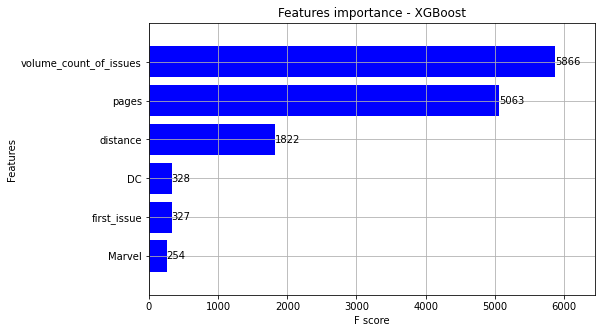

In [171]:
# Graph that
y_true = y_test
y_pred_xgb = y_hat_xgb[:,0]

fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
plot_importance(xgb, height=0.8, title="Features importance - XGBoost", ax=ax, color="blue") 
plt.show()

In [ ]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()  

In [172]:
# Save the model (XGBoost)
xgb.save_model('./model.bst')

**Model Serialization**

Sci-kit learn's default serialization mechanism is the 'pickle' library, which saves a binary model representation to disk.
Load the model using:
```PYTHON
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)
```


In [174]:
# Save model (Pickle)
pickle.dump(xgb, open('model.pkl', 'wb'))